## Practice: Basic Artificial Neural Networks
Credits: this notebook belongs to [Practical DL](https://docs.google.com/forms/d/e/1FAIpQLScvrVtuwrHSlxWqHnLt1V-_7h2eON_mlRR6MUb3xEe5x9LuoA/viewform?usp=sf_link) course by Yandex School of Data Analysis.

We will start working with neural networks on the practice session. Your homework will be to finish the implementation of the layers.

Our goal is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course 

Speaking about the homework (once again, it will be really similar to this seminar), it requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- modules.ipynb with all blocks implemented (except maybe `Conv2d` and `MaxPool2d` layers implementation which are part of 'advanced' version of this homework)

In [1]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Framework

Implement everything in `modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [2]:
# (re-)load layers
%run modules.ipynb

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

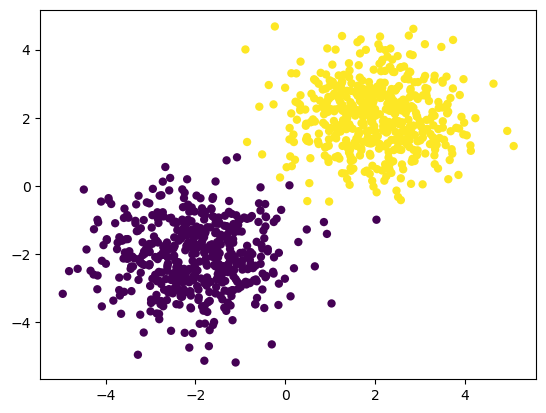

In [3]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [4]:
net = Sequential()
net.add(Linear(2, 2))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

# Test something like that then 

# net = Sequential()
# net.add(Linear(2, 4))
# net.add(ReLU())
# net.add(Linear(4, 2))
# net.add(LogSoftMax())

Linear 2 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [5]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [6]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

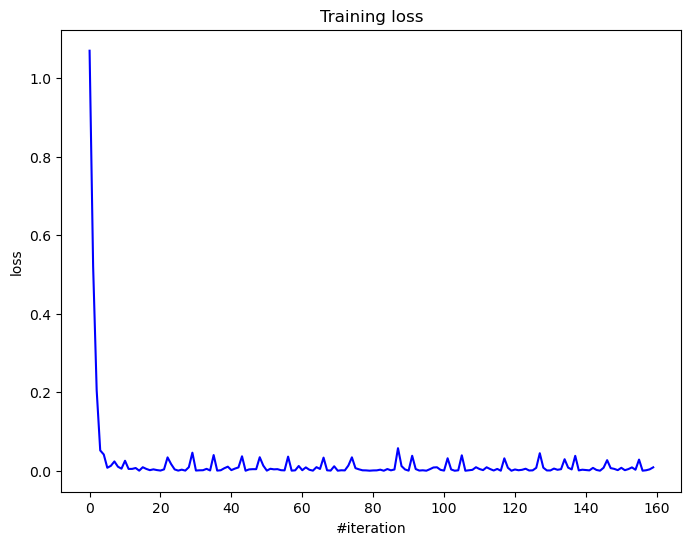

Current loss: 0.008634


In [7]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

# Digit classification 

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset.

In [8]:
import mnist
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()
number_of_features = X_train.shape[1] * X_train.shape[2]
number_of_digits = max(y_train) + 1

In [9]:
print(number_of_features)

784


In [10]:
print(number_of_digits)

10


One-hot encode the labels first.

In [11]:
# Your code goes here. ################################################
def one_hot_encode(y_vector):
    encoded_vector = np.zeros((y_vector.shape[0], np.max(y_vector) + 1))
    for i, val in enumerate(y_vector):
        encoded_vector[i][val] = 1
    return encoded_vector

In [12]:
y_train = one_hot_encode(y_train)
y_val = one_hot_encode(y_val)
y_test = one_hot_encode(y_test)

In [13]:
X_train = np.reshape(X_train, (-1, number_of_features))
X_val = np.reshape(X_val, (-1, number_of_features))
X_test = np.reshape(X_test, (-1, number_of_features))

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5. 

In [14]:
# Your code goes here. ################################################
net_list = list()
activation_list = [ReLU, ELU, LeakyReLU, SoftPlus]
for activation_function in activation_list:
    net = Sequential()
    net.add(Linear(number_of_features, number_of_digits))
    net.add(activation_function())
    net.add(LogSoftMax())
    net_list.append(net)

In [15]:
criterion = ClassNLLCriterion()

# Looping params
n_epoch = 20
batch_size = X_train.shape[0] // 10

def train_net(net_temp, act_func, optimizer, n_epoch, batch_size):
    # Iptimizer params
    if optimizer is sgd_momentum:
        optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
    elif optimizer is adam_optimizer:
        optimizer_config = {'learning_rate' : 1e-1, 'beta1':0.9, 'beta2':0.999, 'epsilon':1e-8}
    optimizer_state = {}
    name_history = act_func + '_' + optimizer.__name__
    loss_history.setdefault(name_history, [])
    for i in range(n_epoch):
        for x_batch, y_batch in get_batches((X_train, y_train), batch_size):
            net_temp.zeroGradParameters()
            
            # Forward
            predictions = net_temp.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)
        
            # Backward
            dp = criterion.backward(predictions, y_batch)
            net_temp.backward(x_batch, dp)
            
            # Update weights
            optimizer(net_temp.getParameters(), 
                      net_temp.getGradParameters(), 
                      optimizer_config,
                      optimizer_state)      
            
            loss_history[name_history].append(loss)
    return net_temp

In [16]:
import time
nets = dict()
loss_history = dict()
for i, af in enumerate(activation_list):
    start = time.time()
    nets[af.__name__ + sgd_momentum.__name__] = train_net(net_list[i], af.__name__, sgd_momentum, n_epoch, batch_size)
    print(f"{af.__name__} + {sgd_momentum.__name__} takes {time.time() - start:.2f} sec.")
    start = time.time()
    nets[af.__name__ + adam_optimizer.__name__] = train_net(net_list[i], af.__name__, adam_optimizer, n_epoch, batch_size)
    print(f"{af.__name__} + {adam_optimizer.__name__} takes {time.time() - start:.2f} sec.")

ReLU + sgd_momentum takes 34.16 sec.
ReLU + adam_optimizer takes 36.03 sec.
ELU + sgd_momentum takes 37.37 sec.
ELU + adam_optimizer takes 39.89 sec.
LeakyReLU + sgd_momentum takes 37.42 sec.
LeakyReLU + adam_optimizer takes 34.63 sec.
SoftPlus + sgd_momentum takes 35.16 sec.
SoftPlus + adam_optimizer takes 36.17 sec.


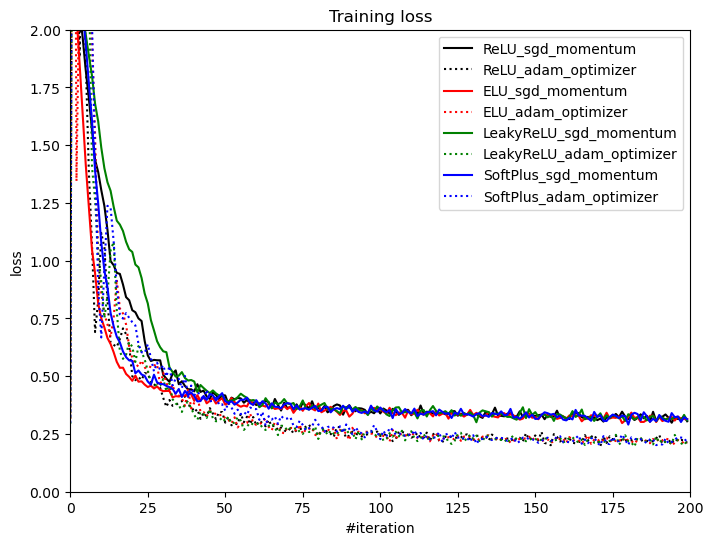

In [17]:
# Visualize
plt.figure(figsize=(8, 6))
    
plt.title("Training loss")
plt.xlabel("#iteration")
plt.ylabel("loss")
styles = ['k-', 'k:', 'r-', 'r:', 'g-', 'g:', 'b-', 'b:']
for x, st in zip(list(loss_history.keys()), styles):
    plt.plot(loss_history[x], st, label=x)
plt.legend()
#plt.yscale("log")
plt.ylim(0, 2)
plt.xlim(0, 200)
plt.show()

Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

In [18]:
# Your answer goes here. ################################################
for key in list(loss_history.keys()):
    print(f"for {key} logloss is {loss_history[key][-1]:.2f}")

for ReLU_sgd_momentum logloss is 0.31
for ReLU_adam_optimizer logloss is 0.21
for ELU_sgd_momentum logloss is 0.31
for ELU_adam_optimizer logloss is 0.21
for LeakyReLU_sgd_momentum logloss is 0.31
for LeakyReLU_adam_optimizer logloss is 0.22
for SoftPlus_sgd_momentum logloss is 0.31
for SoftPlus_adam_optimizer logloss is 0.21


In our case ADAM optimizer leads to the lower loss for ELU, Leaky ReLU and SoftPlus activation functions. As we see good loglosses are achieved for ELU, LeakyReLU and SoftPlus activation function with the ADAM optimizer. Training times are almost equal for all cases.

ADAM optimizer has tunable hyperparameters and reduces to SGD with the right settings, thus there is always a setting for which ADAM optimizer performs equally well. There are often some hyperparameters that perform better, so it's typically equal or better to SGD for optimal hyperparameter choice. 

__Here__ we inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.

In [19]:
net_list_norm = list()
activation_list = [ReLU, ELU, LeakyReLU, SoftPlus]
for activation_function in activation_list:
    net = Sequential()
    net.add(Linear(number_of_features, number_of_digits))
    net.add(activation_function())
    net.add(BatchNormalization())
    net.add(ChannelwiseScaling(number_of_digits))
    net.add(LogSoftMax())
    net_list_norm.append(net)

In [20]:
def train_net_norm(net_temp, act_func, optimizer, n_epoch, batch_size):
    # Iptimizer params
    if optimizer is sgd_momentum:
        optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
    elif optimizer is adam_optimizer:
        optimizer_config = {'learning_rate' : 1e-1, 'beta1':0.9, 'beta2':0.999, 'epsilon':1e-8}
    optimizer_state = {}
    name_history = act_func + '_' + optimizer.__name__
    loss_history_norm.setdefault(name_history, [])
    for i in range(n_epoch):
        for x_batch, y_batch in get_batches((X_train, y_train), batch_size):
            net_temp.zeroGradParameters()
            
            # Forward
            predictions = net_temp.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)
        
            # Backward
            dp = criterion.backward(predictions, y_batch)
            net_temp.backward(x_batch, dp)
            
            # Update weights
            optimizer(net_temp.getParameters(), 
                      net_temp.getGradParameters(), 
                      optimizer_config,
                      optimizer_state)      
            
            loss_history_norm[name_history].append(loss)
    return net_temp

In [21]:
import time
nets_norm = dict()
loss_history_norm = dict()
for i, af in enumerate(activation_list):
    start = time.time()
    nets_norm[af.__name__ + adam_optimizer.__name__] = train_net_norm(net_list_norm[i], af.__name__, adam_optimizer, n_epoch, batch_size)
    print(f"{af.__name__} + {adam_optimizer.__name__} + BatchNormalization takes {time.time() - start:.2f} sec.")

ReLU + adam_optimizer + BatchNormalization takes 36.09 sec.
ELU + adam_optimizer + BatchNormalization takes 35.57 sec.
LeakyReLU + adam_optimizer + BatchNormalization takes 35.50 sec.
SoftPlus + adam_optimizer + BatchNormalization takes 36.71 sec.


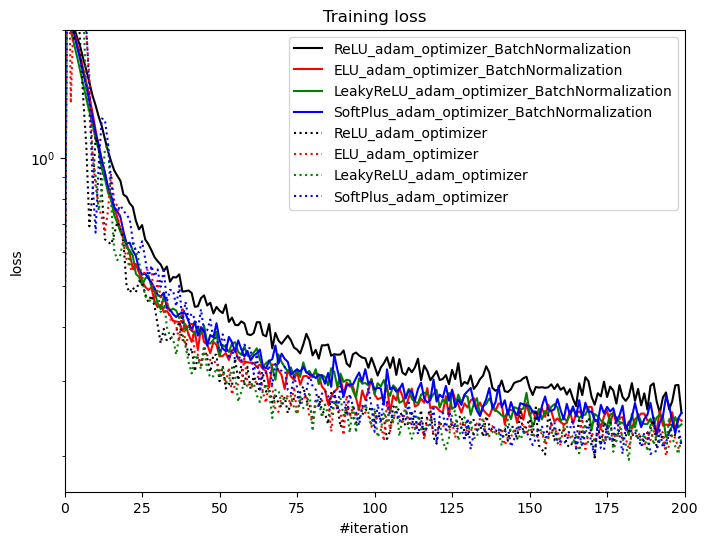

In [22]:
plt.figure(figsize=(8, 6))
    
plt.title("Training loss")
plt.xlabel("#iteration")
plt.ylabel("loss")
styles_norm = ['k-', 'r-', 'g-', 'b-']
for x, st in zip(list(loss_history_norm.keys()), styles_norm):
    plt.plot(loss_history_norm[x], st, label=x+'_BatchNormalization')
styles = ['k:', 'r:', 'g:', 'b:']
i = 0
for x in list(loss_history.keys()):
    if 'adam' in x:
        plt.plot(loss_history[x], styles[i], label=x)
        i += 1
plt.legend()
plt.yscale("log")
plt.ylim(None, 2)
plt.xlim(0, 200)
plt.show()

In [23]:
# Your answer goes here. ################################################
for key in list(loss_history_norm.keys()):
    print(f"for {key} logloss is {loss_history_norm[key][-1]:.2f}")

for ReLU_adam_optimizer logloss is 0.25
for ELU_adam_optimizer logloss is 0.24
for LeakyReLU_adam_optimizer logloss is 0.24
for SoftPlus_adam_optimizer logloss is 0.25


As it can be seen training with the additional `BatchNormalization` and `ChannelwiseScaling` takes not much longer.

By analyzing the training performance of both the ways – without batch normalization with batch normalization – we can conclude that adding the batch normalization between the layers of the network improves the convergence performance. Though the loglosses in our case are a little higher. So using batch normalization should always be considered.

**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

In [24]:
# Your code goes here. ################################################
net = Sequential()
net.add(Linear(number_of_features, number_of_digits))
net.add(BatchNormalization())
net.add(ChannelwiseScaling(number_of_digits))
net.add(SoftPlus())
net.add(LogSoftMax())
net.add(Dropout())

In [25]:
loss_history_norm = {}
net = train_net_norm(net, 'final', adam_optimizer, n_epoch, batch_size)

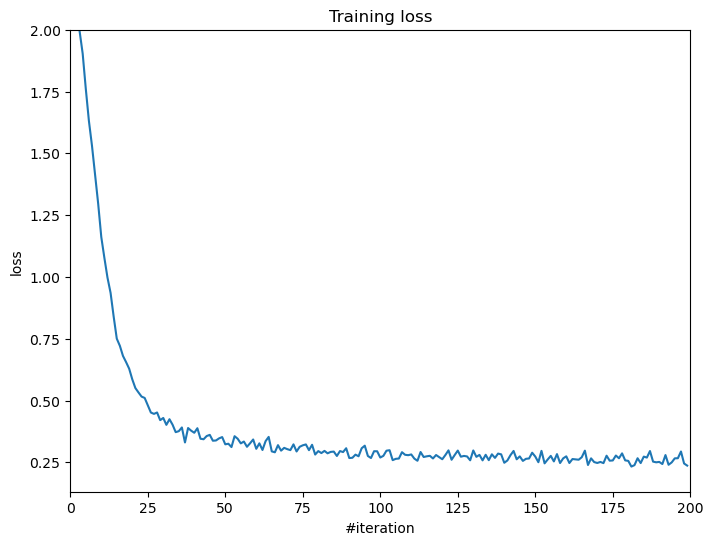

In [26]:
plt.figure(figsize=(8, 6))
    
plt.title("Training loss")
plt.xlabel("#iteration")
plt.ylabel("loss")
plt.plot(loss_history_norm['final_adam_optimizer'])
plt.ylim(None, 2)
plt.xlim(0, 200)
plt.show()

Print here your accuracy on test set. It should be around 90%.

In [27]:
# Your answer goes here. ################################################
from sklearn.metrics import accuracy_score
net.evaluate()
acc = accuracy_score(np.argmax(y_test, axis=1), np.argmax(net.forward(X_test),axis=1))
print(f"Accuracy is {acc * 100:.2f}%")

Accuracy is 92.48%


### Comparing with PyTorch implementation
The last (and maybe the easiest step after compared to the previous tasks: build a network with the same architecture as above now with PyTorch.

You can refer to the `week0_09` or `Lab3_part2` notebooks for hints.

__Good Luck!__

In [28]:
# Your beautiful code here.
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

my_model = nn.Sequential(
    nn.Linear(number_of_features, number_of_digits),
    nn.BatchNorm1d(number_of_digits),
    nn.Softplus(),
    nn.LogSoftmax(dim=1),
    nn.Dropout1d()
)

optimizer = optim.Adam(my_model.parameters(), lr=0.01)

In [29]:
my_model

Sequential(
  (0): Linear(in_features=784, out_features=10, bias=True)
  (1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): Softplus(beta=1, threshold=20)
  (3): LogSoftmax(dim=1)
  (4): Dropout1d(p=0.5, inplace=False)
)

In [30]:
import mnist
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()
number_of_features = X_train.shape[1] * X_train.shape[2]
number_of_digits = max(y_train) + 1

X_train = np.reshape(X_train, (-1, number_of_features))
X_val = np.reshape(X_val, (-1, number_of_features))
X_test = np.reshape(X_test, (-1, number_of_features))

# Looping params
n_epoch = 20
batch_size = X_train.shape[0] // 10

X_train = torch.from_numpy(X_train)
X_val = torch.from_numpy(X_val)
X_test = torch.from_numpy(X_test)

y_train = torch.tensor(y_train)
y_val = torch.tensor(y_val)
y_test = torch.tensor(y_test)

dataset_train = torch.utils.data.TensorDataset(X_train, y_train)
dataset_test = torch.utils.data.TensorDataset(X_test, y_test)
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset_test)

In [31]:
def train(model, optimizer, train_loader, n_epoch, bs):
    model.train()
    loss_his = []
    for i in range(n_epoch):
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            loss_his.append(loss.item())
            optimizer.step()
    return loss_his

In [32]:
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        output = model(data)
        test_loss += F.nll_loss(output, target, reduction='sum').item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [33]:
loss_data = train(my_model, optimizer, train_loader, n_epoch, batch_size)

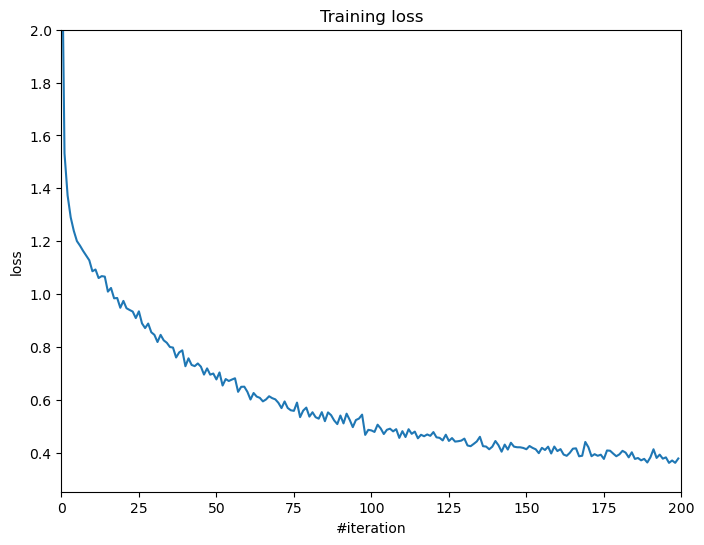

In [34]:
plt.figure(figsize=(8, 6))
    
plt.title("Training loss")
plt.xlabel("#iteration")
plt.ylabel("loss")
plt.plot(loss_data)
plt.ylim(None, 2)
plt.xlim(0, 200)
plt.show()

In [35]:
test(my_model, test_loader)


Test set: Average loss: 0.3716, Accuracy: 9099/10000 (91%)



__Conclusion__: We see that the PyTorch implementation gives almost the same accuracy on the test dataset.